#  **모델링**) 버스승차수요예측 및 온열의자 적지분석
> - 코로나19(감염병)의 확산은 구민들의 대중교통 이용에 영향을 미친다.   
> - 사회적 거리두기가 확대되면 구민의 대중교통 이용패턴이 달라지고 대중교통 이용규모 역시 감소한다.  
> - 코로나 확산이 시작된 2020년을 기점으로 구민들의 대중교통 이용패턴이 어떻게 변화했는지를 실증적으로 분석해보고,
> - 2020년과 2021년 버스승하차인원 데이터를 바탕으로 2021년 겨울 버스승하차인원을 예측해본다.
> - 이를 통해 얻은 예측수요와 기타 환경적인 요인을 고려하여 2021년 겨울 추위녹이소 설치 적지 상위 20위를 제안한다. 

> ## `Importing modules and data`

In [2]:
# API
import requests
import json

# Data format
import feather

# Data processing
import pandas as pd
import numpy as np

# Geopandas, shapely, fiona
import geopandas as gpd
import geojson as gj
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point, Polygon
from pyproj import Proj, CRS, transform
from fiona.crs import from_epsg

# 맵박스
import pydeck as pdk
from mapboxgl.utils import create_color_stops, create_numeric_stops

# 맵박스 API KEY 
MAPBOX_API_KEY = "pk.eyJ1IjoibmtubjIwMDQiLCJhIjoiY2tmM252eXVtMDR3ZTJ3bnN6OGFiZGxpOCJ9.m3xqz8keGqXURVkz2N3znA"

# ML
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, MeanShift, KMeans

# time
from datetime import datetime
from tqdm import tqdm, trange

# xml
import xml.etree.ElementTree as ET

# sql 연동
import pymysql.cursors
from sqlalchemy import create_engine
pymysql.install_as_MySQLdb()
import MySQLdb

from IPython.display import Image
pd.set_option('display.max_columns', None)

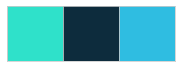

In [1]:
# Data visualization
import matplotlib as mpl
from matplotlib import font_manager,rc
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
palette = ['#2fe1ca', '#0d2c3d','#2fbde1']
sns.set_style('whitegrid')
sns.palplot(palette)

## 

In [16]:
bus_stop = pd.read_feather('도봉구_버스정류장.ft')
bus_stop.set_index('STOP_NO', inplace=True)
bus_stop.head()

,STOP_NM,XCODE,YCODE,heat_chair,bis
STOP_NO,,,,,
10001,도봉산역,127.045432,37.689195,0,1
10002,도봉산역,127.045637,37.688785,0,1
10003,도봉한신아파트,127.045919,37.684052,0,1
10004,도봉한신아파트,127.045915,37.682572,0,1
10005,서울북부지방법원.검찰청.도봉역성황당,127.044915,37.677729,0,1
...,...,...,...,...,...
10841,효문중학교,127.018349,37.651572,0,0
10842,효문중학교,127.018331,37.651568,0,0
10843,도봉중학교후문,127.045045,37.671165,0,0


906864